In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn import tree
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

In [2]:
# Opening datasets
X_optimal = pd.read_csv('X_optimal.csv')
y_optimal = pd.read_csv('y_optimal.csv')

print(X_optimal.shape)
print(y_optimal.shape)

(319031, 8)
(319031, 1)


In [3]:
X_optimal.head()

,half_seconds_remaining,game_seconds_remaining,yardline_100,down,humidity,temperature,score_differential,ydstogo
0,1793.0,3593.0,58.0,1.0,32,73,0.0,10
1,1756.0,3556.0,53.0,2.0,32,73,0.0,5
2,1715.0,3515.0,56.0,3.0,32,73,0.0,8
3,1696.0,3496.0,98.0,1.0,32,73,0.0,10
4,1660.0,3460.0,98.0,2.0,32,73,0.0,10


In [4]:
X = X_optimal.copy()
y = y_optimal.play_type

In [5]:
print(X.shape)
print(y.shape)

(319031, 8)
(319031,)


In [6]:
# applying SMOTE to our data and checking the class counts
X, y = SMOTE().fit_resample(X, y)
print(X.shape)
print(y.shape)

(372726, 8)
(372726,)


In [7]:
y

array(['pass', 'run', 'pass', ..., 'run', 'run', 'run'], dtype=object)

In [8]:
# Transforming features
pt = PowerTransformer()
pt.fit(X)
X = pt.transform(X)


In [9]:
X

array([[ 1.50797748,  1.55444502,  0.21775508, ...,  0.7648242 ,
         0.1069377 ,  0.39694262],
       [ 1.45958328,  1.52823707,  0.01286846, ...,  0.7648242 ,
         0.1069377 , -0.92307876],
       [ 1.4055209 ,  1.49909444,  0.1357159 , ...,  0.7648242 ,
         0.1069377 , -0.1156421 ],
       ...,
       [ 1.20139469, -0.05869327, -0.59114504, ..., -0.28247722,
         1.04433749, -0.80997449],
       [ 0.68491805, -0.40390774,  0.78503849, ..., -0.26923953,
         0.32200592,  0.2424868 ],
       [ 1.38089204,  0.06223753,  1.74144033, ..., -1.02035356,
         0.39032289,  0.39694262]])

In [10]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
print(X_train.shape)
print(y_train.shape)

(279544, 8)
(279544,)


In [12]:
print(X_test.shape)
print(y_test.shape)

(93182, 8)
(93182,)


In [13]:
models = [
    tree.DecisionTreeClassifier(), GaussianNB(),
#   SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=200),
    RandomForestClassifier(n_estimators=200), xgb.XGBClassifier(random_state=1,learning_rate=0.01)
]

In [14]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("f1 - {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))
    print("Accuracy - {}: {}".format(estimator.__class__.__name__, accuracy_score(expected, predicted)))

for model in models:
    score_model(X_train, y_train, model)

f1 - DecisionTreeClassifier: 0.9999142955090846
Accuracy - DecisionTreeClassifier: 0.9999141458947428
f1 - GaussianNB: 0.6654144520701102
Accuracy - GaussianNB: 0.6520798156998541
f1 - SGDClassifier: 0.6719238523316919
Accuracy - SGDClassifier: 0.6449002661477263
f1 - KNeighborsClassifier: 0.7922058864633703
Accuracy - KNeighborsClassifier: 0.7872463726640528
f1 - LogisticRegression: 0.6658131653715812
Accuracy - LogisticRegression: 0.650766963340297
f1 - LogisticRegressionCV: 0.6657317467191872
Accuracy - LogisticRegressionCV: 0.6521120109893255
f1 - BaggingClassifier: 0.9843720702139014
Accuracy - BaggingClassifier: 0.984496179492316
f1 - ExtraTreesClassifier: 0.9999142955090846
Accuracy - ExtraTreesClassifier: 0.9999141458947428
f1 - RandomForestClassifier: 0.9999143053016454
Accuracy - RandomForestClassifier: 0.9999141458947428
f1 - XGBClassifier: 0.7368996353288167
Accuracy - XGBClassifier: 0.7003584408894485


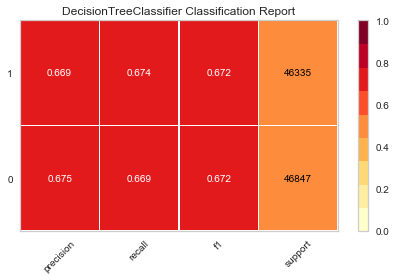

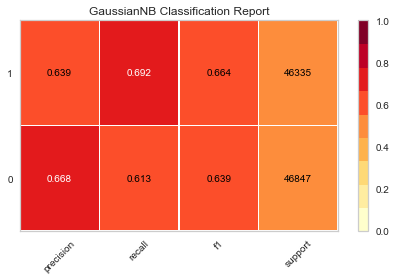

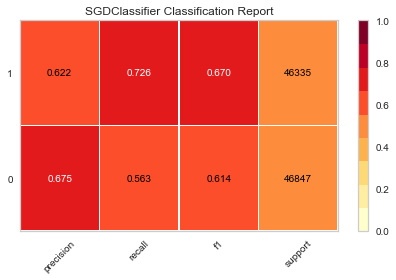

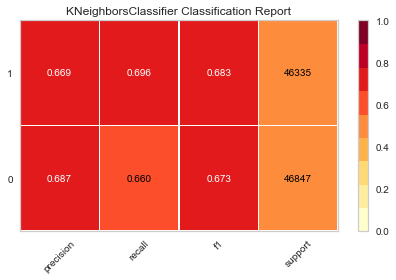

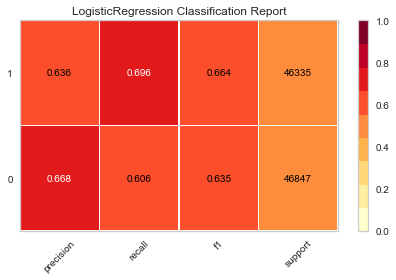

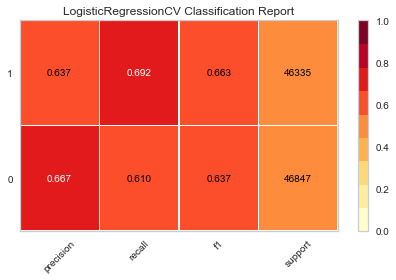

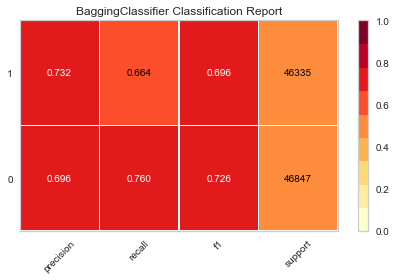

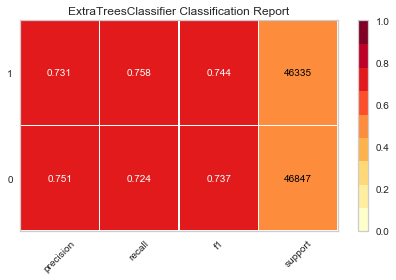

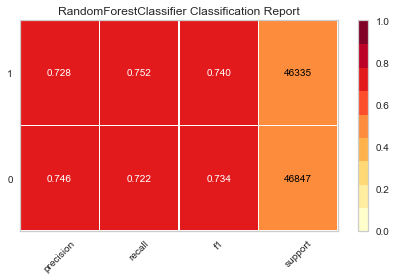

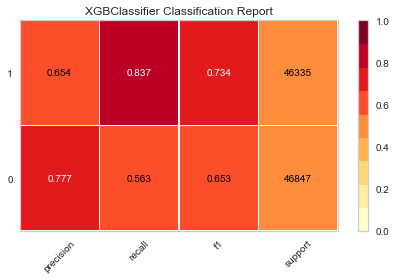

In [15]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

def visualize_model(model):
    """
    Test various estimators
    """
    visualizer = ClassificationReport(model, support=True)
    
    visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()   # Finalize and show the figure

for model in models:
    visualize_model(model)

In [ ]:
str(model)[:12]

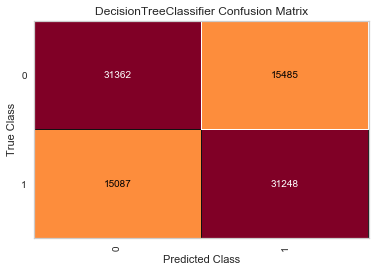

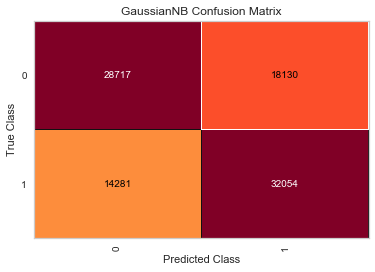

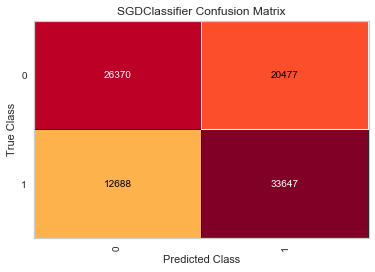

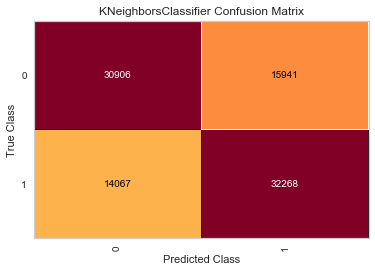

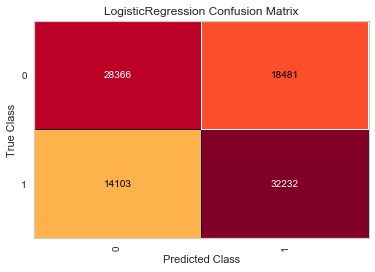

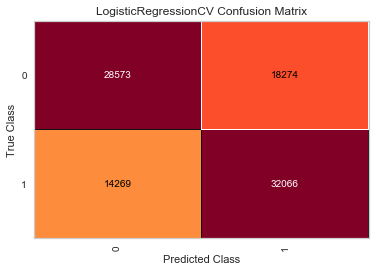

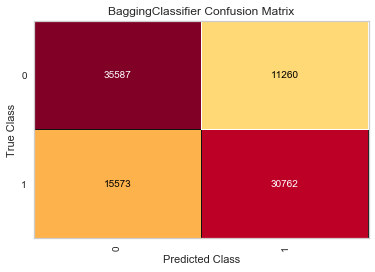

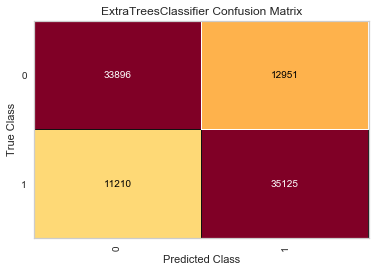

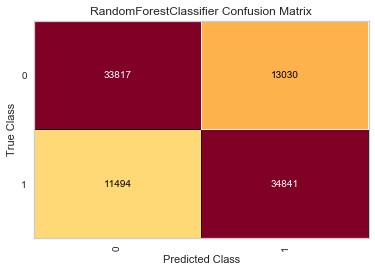

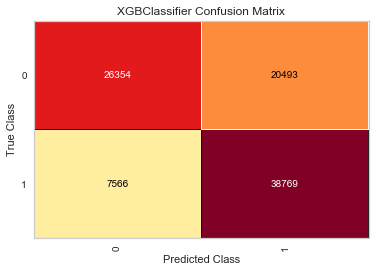

In [18]:
def confustion_matrix(model, **kwargs):

    model = model

    matrix = ConfusionMatrix(
        model
    )
    
    matrix.fit(X_train, y_train)
    matrix.score(X_test, y_test)

    matrix.show()
    
for model in models:
    confustion_matrix(model)

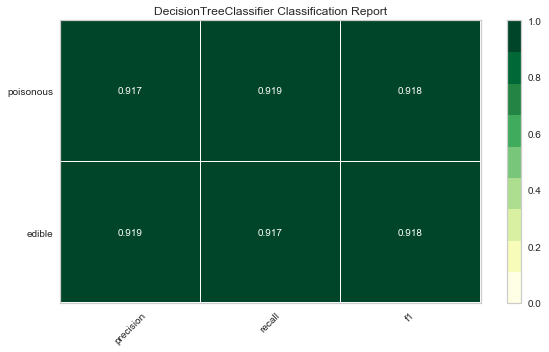

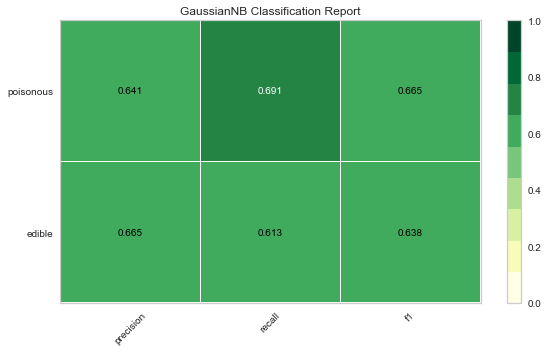

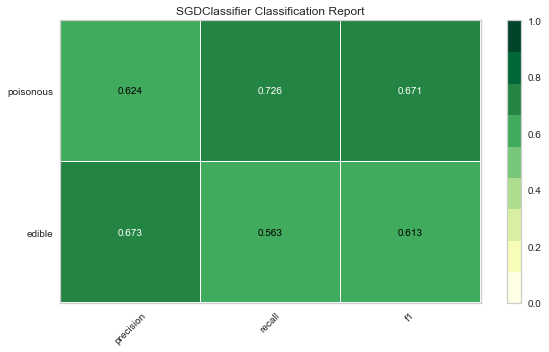

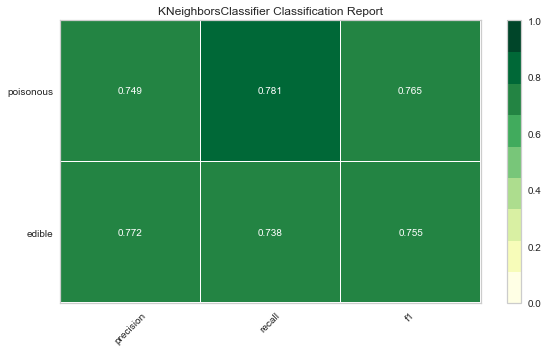

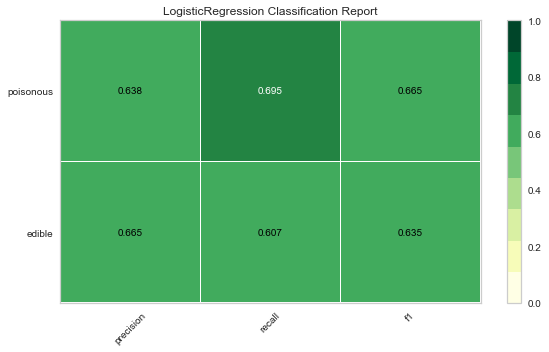

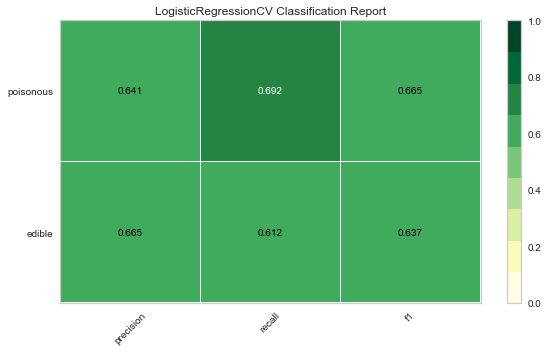

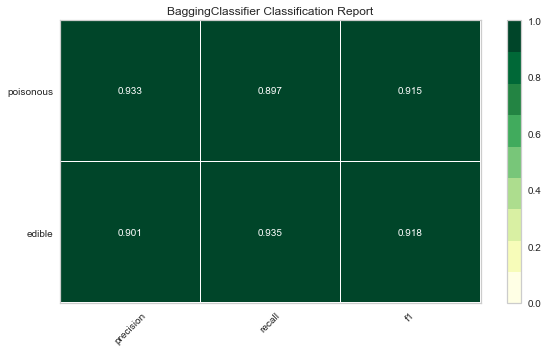

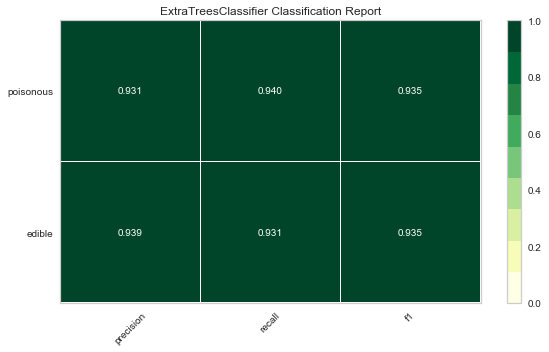

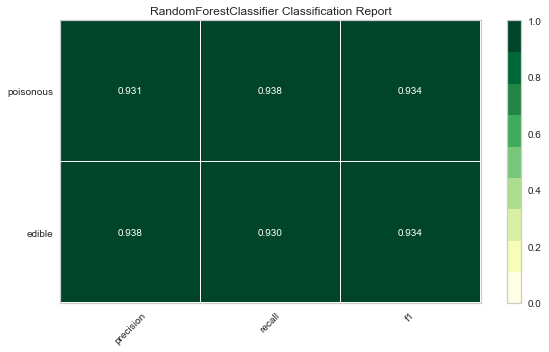

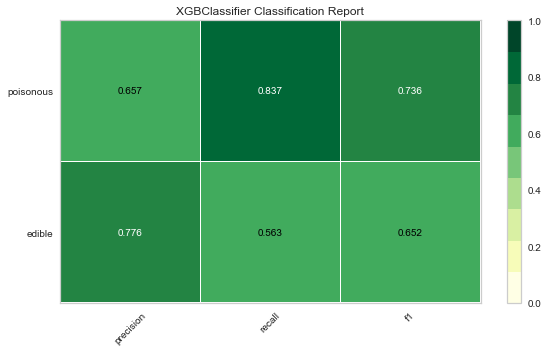

In [19]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['edible', 'poisonous'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

for model in models:
    visualize_model(X, y, model)